In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import numpy as np
import gzip
import sys
import os
import seaborn as sns


In [4]:
import mediator_was.processing.gtex as gtex
import mediator_was.processing.predixcan as predixcan

In [5]:
measured = gtex.load_expression()

In [6]:
measured.head()

,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,GTEX-117YW,GTEX-1192W,GTEX-11DXW,GTEX-11DXX,...,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVTK,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
name,,,,,,,,,,,,,,,,,,,,,
RP11-34P13.7,0.182160,2.176759,-0.327403,-1.563249,-0.798158,-0.690825,-1.215465,-0.626521,-0.635544,2.753304,...,-0.709723,-0.114862,1.141439,-2.263599,-0.107422,-1.427651,2.103773,-1.185074,0.430727,-0.070303
CICP27,0.182160,1.073190,-0.479942,-1.845969,-0.866108,-1.099875,-0.973342,-0.304087,-0.626521,1.984522,...,-1.009605,-0.025883,0.758123,-2.263599,-0.152166,-1.073190,2.371853,-1.350077,0.430727,-0.048081
RP11-34P13.15,0.189683,0.488256,1.314165,-2.518087,-1.127368,-0.573403,-1.192569,-0.556058,-0.331307,0.099988,...,-0.311840,0.055485,0.622028,-1.643425,0.949861,-1.770186,0.768016,-1.170281,-0.319612,-0.107422
RP11-34P13.16,0.753204,0.304087,1.514917,-2.518087,-0.955682,-1.170281,-0.753204,0.126034,-0.327403,-0.238866,...,-0.414557,-0.370628,0.386515,-2.040526,0.414557,-1.888215,-0.114862,-2.263599,-0.509189,-0.197217
RP11-34P13.14,0.513403,0.343047,1.703388,-1.806781,-0.327403,-1.469885,0.273250,0.662931,0.538879,-0.382535,...,-0.250294,-1.563249,0.204762,-1.314165,1.350077,-0.829044,-0.926893,-1.387820,-0.599750,0.777984


In [7]:
predicted = predixcan.load_predicted('../../data/predixcan/predictions.minus-hla.alpha0.5.tsv.gz')

In [8]:
predicted.head()

,GTEX-P4PP,GTEX-PWO3,GTEX-SNOS,GTEX-PW2O,GTEX-RU72,GTEX-VJYA,GTEX-U3ZH,GTEX-PLZ4,GTEX-P44G,GTEX-WOFL,...,GTEX-YF7O,GTEX-11TTK,GTEX-Y3IK,GTEX-12WSE,GTEX-1212Z,GTEX-YEC3,GTEX-11ONC,GTEX-ZZPT,GTEX-ZVTK,GTEX-XBEC
UBE2Q1,-0.109752,-0.061552,0.132662,0.040619,-0.152046,0.067382,-0.058848,0.118862,0.052234,-0.025903,...,0.117869,0.033480,0.077085,-0.040651,0.021496,0.001673,0.128743,0.085642,0.010564,-0.051246
RNF14,-0.336858,-0.136505,-0.346932,0.069631,-0.158922,-0.323628,-0.358662,-0.358662,0.048641,-0.164706,...,-0.152526,-0.158922,-0.129295,-0.172528,-0.172528,0.033608,-0.337234,-0.156508,-0.323628,-0.137504
UBE2Q2,0.163730,0.170236,-0.037282,0.275136,0.075633,-0.173713,0.300163,0.445823,0.073294,0.117410,...,0.212563,0.205977,-0.089137,-0.045314,0.126726,0.065451,0.281750,0.167068,0.188498,0.213381
RNF10,-0.045206,-0.093752,-0.082642,-0.058915,0.028050,-0.068585,0.018337,-0.055911,-0.047145,-0.034460,...,-0.031364,-0.071043,0.040571,0.034627,-0.063676,-0.005278,0.029508,-0.043493,-0.041957,-0.081831
RNF13,0.843348,0.010289,0.388427,0.003117,0.069427,0.230263,-0.022896,-0.052079,0.035352,0.406686,...,0.045204,0.514724,0.432803,0.009890,0.077117,0.407067,0.413370,-0.034946,0.010903,0.041893


In [8]:
combined = pd.concat([measured, predicted],
                      keys=['Measured', 'Predicted'])
combined = combined.swaplevel(0, 1)
found_in_both = set(measured.index).intersection(predicted.index)
combined = combined.ix[found_in_both, :]
combined = combined.dropna(axis=1,)

In [9]:
combined.head()

GTEX-111YS  GTEX-1122O  GTEX-1128S  GTEX-113IC  GTEX-113JC  \
name                                                                           
UBE2Q1 Measured     1.060130    0.823842   -2.753304    0.296352   -1.003470   
       Predicted   -0.014974    0.090753    0.092210   -0.043855    0.024695   
RNF14  Measured     0.635544   -0.055485   -0.714487    0.463414   -1.397571   
       Predicted   -0.159453   -0.360858   -0.349533   -0.360858   -0.339966   
UBE2Q2 Measured    -0.564709   -0.728877    0.025883    1.672655    0.447011   

                  GTEX-117XS  GTEX-117YW  GTEX-1192W  GTEX-11DXW  GTEX-11DXX  \
name                                                                           
UBE2Q1 Measured    -1.427651   -0.829044   -0.955682   -0.798158    1.113516   
       Predicted    0.046845    0.056050    0.135112   -0.079794   -0.002272   
RNF14  Measured    -1.866676   -1.866676   -1.331907   -1.615536    0.350900   
       Predicted   -0.360858   -0.165200   -0.344138   -0.360858   -0.334571   
UBE2Q2 Measured    -0.882362   -0.339128   -0.129761   -0.915590   -0.608625   

                    ...      GTEX-ZVE2  GTEX-ZVP2  GTEX-ZVT2  GTEX-ZVT3  \
name                ...                                                   
UBE2Q1 Measured     ...      -0.390502   0.204762   0.728877  -1.231090   
       Predicted    ...       0.097856   0.086071   0.142650   0.056167   
RNF14  Measured     ...       1.538633   0.653748   0.398495  -0.394495   
       Predicted    ...      -0.319075  -0.339966  -0.313679  -0.323246   
UBE2Q2 Measured     ...      -0.997372   0.719267  -0.250294   1.148560   

                  GTEX-ZVT4  GTEX-ZVTK  GTEX-ZVZP  GTEX-ZVZQ  GTEX-ZXES  \
name                                                                      
UBE2Q1 Measured   -0.346970  -0.938315   1.469885  -0.159651   1.359332   
       Predicted   0.045658   0.007399   0.101746  -0.038023   0.004101   
RNF14  Measured   -1.984522  -1.350077  -0.608625  -0.219888   0.122308   
       Predicted  -0.334571  -0.328642  -0.345544  -0.174767  -0.328642   
UBE2Q2 Measured   -0.319612   1.417482  -1.086436   0.242672   0.148427   

                  GTEX-ZXG5  
name                         
UBE2Q1 Measured    0.055485  
       Predicted  -0.058071  
RNF14  Measured   -0.798158  
       Predicted  -0.360858  
UBE2Q2 Measured    0.839516  

[5 rows x 338 columns]

In [ ]:
full_correlation = combined.T.corr()

In [79]:
full_correlation.to_csv('../../data/predixcan/gtex.full.correlation.tsv.gz',
                       compression='gzip',
                       sep='\t')

In [11]:
measured_vs_predicted = full_correlation.xs('Measured', level=1).T.xs('Predicted', level=1)

In [12]:
measured_vs_predicted[measured_vs_predicted.columns[:5]].head(5)

name,UBE2Q1,RNF14,UBE2Q2,RNF10,RNF13
name,,,,,
UBE2Q1,0.076979,-0.055182,0.023002,-0.099670,-0.009286
RNF14,0.004466,0.178147,0.002010,0.031206,-0.075317
UBE2Q2,-0.073829,-0.006907,0.105296,-0.046268,0.099965
RNF10,-0.134089,-0.061876,-0.056943,0.038593,-0.076906
RNF13,-0.032777,-0.047066,-0.143675,0.137139,0.082196


In [24]:
measured_vs_predicted.to_csv('../../data/predixcan/measured_vs_predicted.correlation.full.tsv',
                            sep="\t")

In [26]:
measured_vs_measured = full_correlation.xs('Measured', level=1).T.xs('Measured', level=1)
measured_vs_measured.to_csv('../../data/predixcan/measured_vs_measured.correlation.full.tsv',
                            sep="\t")

In [27]:
predicted_vs_predicted = full_correlation.xs('Predicted', level=1).T.xs('Predicted', level=1)
predicted_vs_predicted.to_csv('../../data/predixcan/predicted_vs_predicted.correlation.full.tsv',
                            sep="\t")

### To just get a feel for the data, let's see all the plots that were show and not shown in Predixcan Main Paper

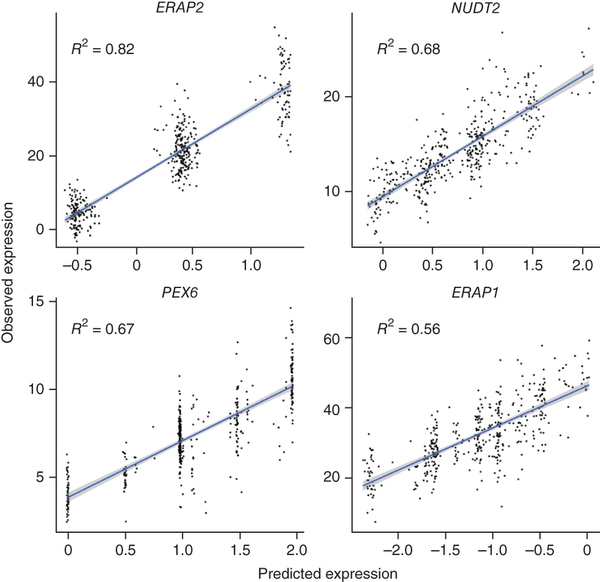

In [28]:
paper_genes = ['ERAP2', 'NUDT2', 'PEX6', 'ERAP1']

In [145]:
predicted_correlation = np.diag(measured_vs_predicted)
predicted_correlation = pd.DataFrame(predicted_correlation)
predicted_correlation.index = measured_vs_predicted.columns
predicted_correlation.ix[paper_genes]

,0
name,
ERAP2,0.676513
NUDT2,0.461575
PEX6,0.555812
ERAP1,0.287413


In [261]:
def multi_gene_plot(genes):
    combined_gene_df = []
    for gene in genes:
        gene_df = combined.ix[gene].T
        gene_df['Gene'] = gene
        combined_gene_df.append(gene_df)
    combined_gene_df = pd.concat(combined_gene_df)
    sns.lmplot('Predicted', 'Measured', col='Gene', data=combined_gene_df)

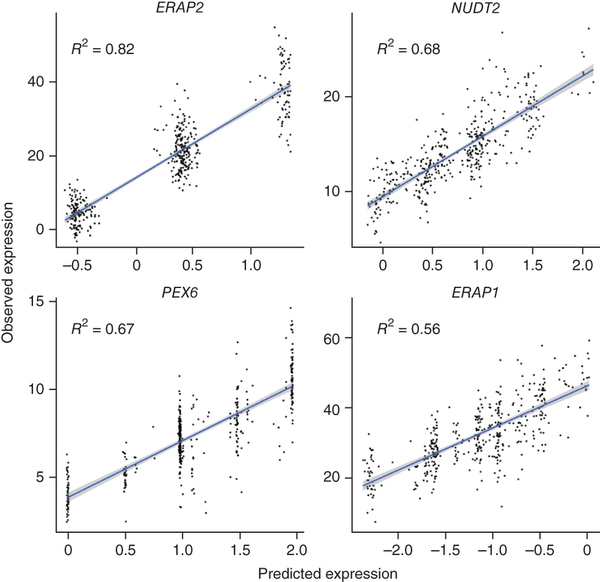

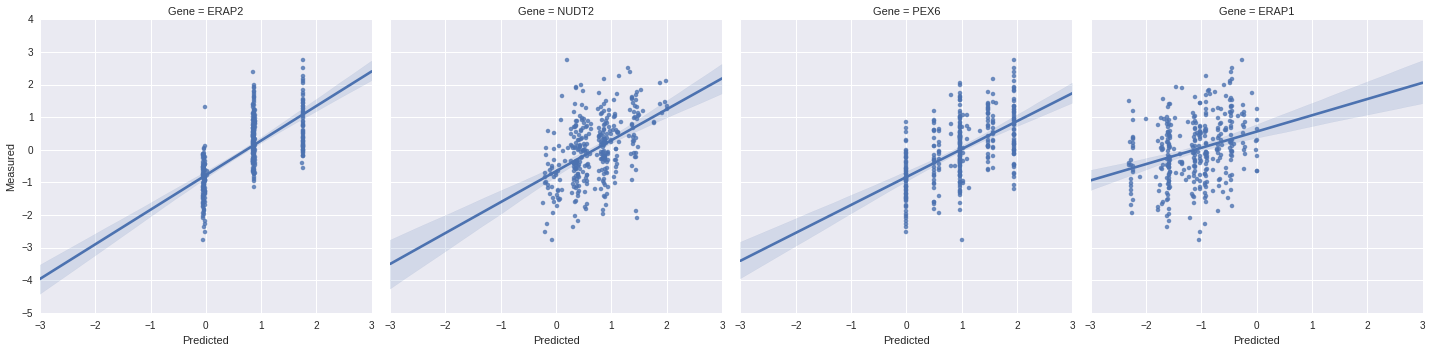

In [262]:
multi_gene_plot(paper_genes)
from IPython.display import Image
Image('http://www.nature.com/ng/journal/v47/n9/images_article/ng.3367-F5.jpg', height="300", width="300")

# Look at the attenuation bias by looking at Var(Measured - Predicted) vs Var(Predicted)

In [282]:
combined.loc(axis=0)[:,'Measured'].head()

,,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,GTEX-117YW,GTEX-1192W,GTEX-11DXW,GTEX-11DXX,...,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVTK,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
name,,,,,,,,,,,,,,,,,,,,,,
UBE2Q1,Measured,1.060130,0.823842,-2.753304,0.296352,-1.003470,-1.427651,-0.829044,-0.955682,-0.798158,1.113516,...,-0.390502,0.204762,0.728877,-1.231090,-0.346970,-0.938315,1.469885,-0.159651,1.359332,0.055485
RNF14,Measured,0.635544,-0.055485,-0.714487,0.463414,-1.397571,-1.866676,-1.866676,-1.331907,-1.615536,0.350900,...,1.538633,0.653748,0.398495,-0.394495,-1.984522,-1.350077,-0.608625,-0.219888,0.122308,-0.798158
UBE2Q2,Measured,-0.564709,-0.728877,0.025883,1.672655,0.447011,-0.882362,-0.339128,-0.129761,-0.915590,-0.608625,...,-0.997372,0.719267,-0.250294,1.148560,-0.319612,1.417482,-1.086436,0.242672,0.148427,0.839516
RNF10,Measured,0.475798,1.079789,1.127368,-2.617812,-0.062892,0.018487,-0.803252,-1.047248,-1.060130,0.653748,...,1.672655,-0.876918,1.314165,-1.247022,0.088847,-1.215465,0.099988,-0.709723,-0.339128,-0.273250
RNF13,Measured,0.304087,1.845969,-1.113516,0.335215,1.263277,-1.984522,-2.371853,-0.915590,-1.672655,1.247022,...,0.839516,0.743420,1.588849,-0.938315,0.366671,-0.662931,0.709723,-1.427651,1.060130,1.296828


In [283]:
combined.loc(axis=0)[:,'Predicted'].head()

,,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,GTEX-117YW,GTEX-1192W,GTEX-11DXW,GTEX-11DXX,...,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVTK,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
name,,,,,,,,,,,,,,,,,,,,,,
UBE2Q1,Predicted,-0.014974,0.090753,0.092210,-0.043855,0.024695,0.046845,0.056050,0.135112,-0.079794,-0.002272,...,0.097856,0.086071,0.142650,0.056167,0.045658,0.007399,0.101746,-0.038023,0.004101,-0.058071
RNF14,Predicted,-0.159453,-0.360858,-0.349533,-0.360858,-0.339966,-0.360858,-0.165200,-0.344138,-0.360858,-0.334571,...,-0.319075,-0.339966,-0.313679,-0.323246,-0.334571,-0.328642,-0.345544,-0.174767,-0.328642,-0.360858
UBE2Q2,Predicted,-0.008919,0.079141,0.197502,0.153488,0.247067,0.103942,0.148243,0.117820,0.003494,0.030216,...,0.190999,0.091888,0.089101,0.021049,0.182677,0.191851,0.214651,0.235011,0.150811,0.081046
RNF10,Predicted,0.041601,-0.023125,-0.063442,-0.082105,-0.046722,-0.038235,0.070691,0.002947,0.016757,-0.017554,...,-0.016741,-0.079400,-0.002664,0.003742,0.055866,-0.029078,-0.009818,0.060442,0.028936,0.001620
RNF13,Predicted,0.000000,0.353058,0.353058,0.308224,0.044834,0.000000,0.000000,0.353058,0.000000,0.000000,...,0.353058,0.044834,0.353058,0.000000,0.353058,0.000000,0.044834,0.353058,0.044834,0.353058


In [289]:
difference = combined.loc(axis=0)[:,'Measured']-combined.loc(axis=0)[:,'Predicted'].values
difference.index = difference.index.droplevel(1)

In [290]:
difference.head()

,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,GTEX-117YW,GTEX-1192W,GTEX-11DXW,GTEX-11DXX,...,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVTK,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
name,,,,,,,,,,,,,,,,,,,,,
UBE2Q1,1.075104,0.733088,-2.845514,0.340206,-1.028165,-1.474496,-0.885094,-1.090793,-0.718365,1.115788,...,-0.488358,0.118691,0.586227,-1.287258,-0.392628,-0.945713,1.368139,-0.121627,1.355231,0.113556
RNF14,0.794997,0.305373,-0.364953,0.824272,-1.057605,-1.505818,-1.701476,-0.987769,-1.254678,0.685470,...,1.857708,0.993714,0.712174,-0.071249,-1.649952,-1.021436,-0.263081,-0.045121,0.450950,-0.437300
UBE2Q2,-0.555790,-0.808018,-0.171620,1.519167,0.199944,-0.986304,-0.487371,-0.247582,-0.919084,-0.638841,...,-1.188371,0.627379,-0.339395,1.127511,-0.502289,1.225631,-1.301087,0.007661,-0.002384,0.758470
RNF10,0.434197,1.102915,1.190810,-2.535706,-0.016170,0.056722,-0.873943,-1.050195,-1.076886,0.671302,...,1.689396,-0.797518,1.316830,-1.250764,0.032981,-1.186387,0.109806,-0.770164,-0.368064,-0.274870
RNF13,0.304087,1.492910,-1.466575,0.026990,1.218443,-1.984522,-2.371853,-1.268648,-1.672655,1.247022,...,0.486457,0.698587,1.235791,-0.938315,0.013613,-0.662931,0.664889,-1.780709,1.015296,0.943770


In [297]:
attenuation = pd.concat([difference.std(axis=1), 
                         predicted.std(axis=1)], axis=1)\
                       .dropna(axis=0)
attenuation.columns = ['Measurement Error SD', 'Predicted SD']

In [304]:
def calculate_reliability_ratio(series):
    variance_x = np.power(series['Measurement Error SD'], 2)
    variance_error = np.power(series['Predicted SD'], 2)
    return (variance_x) / (variance_error + variance_x)

In [305]:
attenuation['Attenuation'] = attenuation.apply(calculate_reliability_ratio,
                                              axis=1)

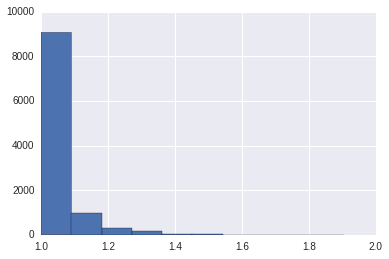

In [320]:
attenuation['Attenuation'].map(lambda x: 1/(x+0.000000001)).hist()

In [321]:
attenuation['Attenuation'].map(lambda x: 1/(x+0.000000001)).describe()

count    10616.000000
mean         1.043518
std          0.075771
min          1.000001
25%          1.003628
50%          1.014174
75%          1.048548
max          1.903562
Name: Attenuation, dtype: float64

In [322]:
attenuation.sort(['Attenuation']).head()

,Measurement Error SD,Predicted SD,Attenuation
RPS28,0.663247,0.630455,0.525331
CCDC163P,0.636819,0.604731,0.525828
C17orf97,0.662122,0.605294,0.544748
BEGAIN,0.730371,0.645360,0.561558
XRRA1,0.643691,0.562772,0.566771


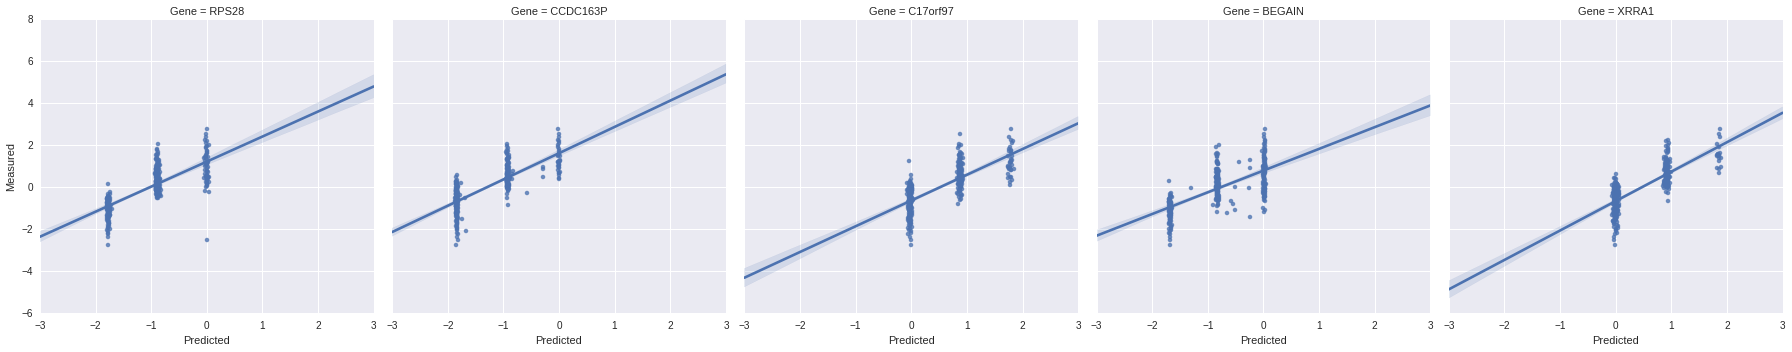

In [319]:
multi_gene_plot(attenuation.sort(['Attenuation']).head().index)

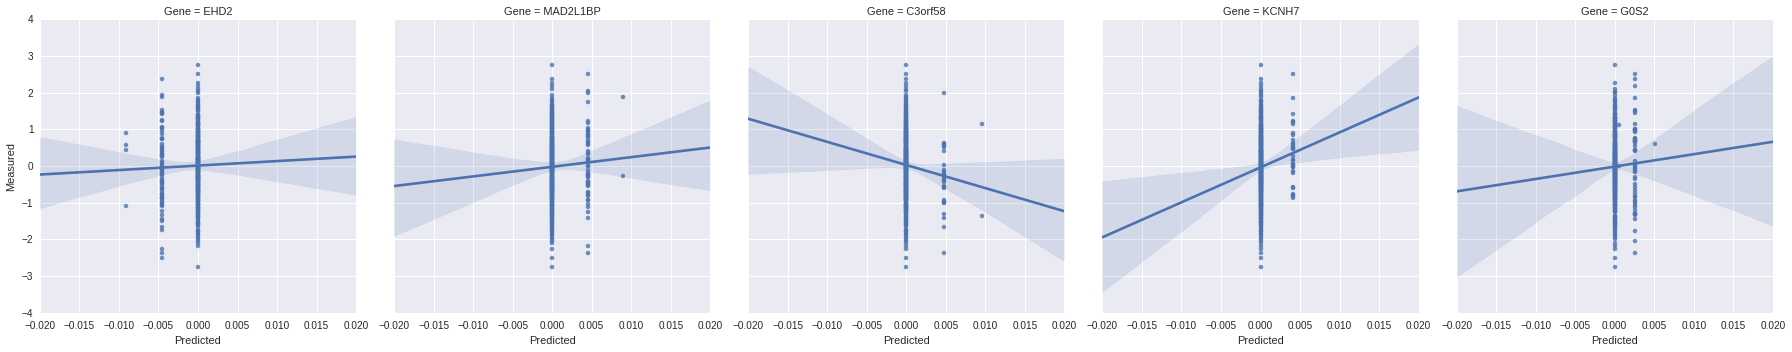

In [323]:
multi_gene_plot(attenuation.sort(['Attenuation']).tail().index)

In [325]:
attenuation.to_csv('../../data/predixcan/gtex.attenuation.tsv', sep='\t')

In [326]:
!head '../../data/predixcan/gtex.attenuation.tsv'

	Measurement Error SD	Predicted SD	Attenuation
RPS28	0.663246809486	0.630455113069	0.525330906121
CCDC163P	0.636818771281	0.604730596735	0.525828014166
C17orf97	0.662122304012	0.605293605769	0.544748274644
BEGAIN	0.730370928322	0.645359736127	0.561558428169
XRRA1	0.643691345208	0.562771793202	0.566771336654
RPL9	0.673893961311	0.583934664148	0.571155554502
AFAP1	0.678111003925	0.582610273073	0.575318674686
ERAP2	0.727595183046	0.62388425652	0.576289554538
GSTM3	0.724312059167	0.612814770441	0.582809931694


# Changing the mean because of scaling. Instead of looking at Var(Measured - Predicted), look at Var(Measured - W*Predicted)

i.e.

First fit, M = W*P + e, then look at the variance of e

#### So far, so good in terms of our estimation. Let's fit linear models and save the results.'

In [159]:
import statsmodels.api as sm

In [208]:
# Toy example
gene = 'ERAP2'
model = sm.OLS(combined.ix[gene,'Measured'], combined.ix[gene, 'Predicted'])
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     ('ERAP2', 'Measured')   R-squared:                       0.194
Model:                               OLS   Adj. R-squared:                  0.191
Method:                    Least Squares   F-statistic:                     80.87
Date:                   Sun, 25 Oct 2015   Prob (F-statistic):           1.77e-17
Time:                           14:36:17   Log-Likelihood:                -438.20
No. Observations:                    338   AIC:                             878.4
Df Residuals:                        337   BIC:                             882.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------

In [211]:
np.std(results.resid)

0.8211695755782715

In [210]:
coefficients = {}
coefficients[gene] = (results.params, results.bse)
residuals = {}
residuals[gene] = results.resid

In [187]:
coefficients, residuals[gene].head()

({'ERAP2': ((ERAP2, Predicted)    0.448616
   dtype: float64, (ERAP2, Predicted)    0.049886
   dtype: float64)}, GTEX-111YS   -1.023571
 GTEX-1122O   -0.802536
 GTEX-1128S    0.626108
 GTEX-113IC    0.078283
 GTEX-113JC    0.747230
 dtype: float64)

In [218]:
genes = combined.index.get_level_values(0)
coefficients = {}
residuals = {}

In [223]:
results.params.values[0]

0.2406357218570683

In [224]:
for gene in genes:
    model = sm.OLS(combined.ix[gene,'Measured'], combined.ix[gene, 'Predicted'])
    results = model.fit()
    coefficients[gene] = (results.params.values[0], results.bse.values[0])
    residuals[gene] = results.resid

In [194]:
residuals_df = pd.DataFrame.from_dict(residuals, orient='index')

In [195]:
residuals_df.head()

,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,GTEX-117YW,GTEX-1192W,GTEX-11DXW,GTEX-11DXX,...,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVTK,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
A2M,-0.771344,-0.496332,-0.847411,-2.262840,0.905703,0.671178,-0.257638,0.299022,0.123698,-1.095567,...,0.307705,-1.004540,-0.982902,-0.247152,-0.174039,-0.870201,-0.682609,0.346787,-1.422883,-1.872697
A4GALT,-0.122091,-1.437904,-0.053141,-2.050005,-0.059717,1.483174,0.743860,0.747602,1.616211,-2.352712,...,0.951563,0.106473,-0.820637,0.144646,1.461991,0.520282,-0.503730,1.537048,-0.964963,-1.814097
AACS,0.037066,-1.406510,2.349426,0.001322,-0.535400,1.128191,1.843245,0.393010,0.735432,-1.541961,...,-1.268252,0.930749,-0.105887,0.498033,0.173543,1.304295,0.036786,1.375711,-0.711217,0.339407
AAGAB,0.323449,-0.051377,0.742155,1.852680,-1.976394,1.133901,-1.689061,-0.647370,-0.822713,-0.119795,...,0.140539,0.351868,0.180166,-0.444178,-1.235864,-0.757682,-0.815730,-0.311517,-0.660435,-0.032568
AAK1,-0.994842,-0.340208,2.697165,-0.654927,0.846673,1.041740,2.089583,0.597043,0.412951,0.098977,...,-0.226689,-1.177864,-0.975821,0.698634,0.725276,1.843311,-0.787137,0.475732,-0.786493,1.274875


In [212]:
std_errors = residuals_df.std(axis=1)
std_errors.sort()

In [213]:
std_errors.head()

HBA2       0.682191
XRRA1      0.688829
CPA5       0.694524
SLC12A1    0.700996
AFAP1      0.706581
dtype: float64

In [214]:
std_errors.tail()

KDM2B       0.986633
LIPH        0.986633
ABCD2       0.986633
INCENP      0.986633
SLC16A14    0.986633
dtype: float64

### Why do multiple genes have the same standard error and why is it bounded to 0.986 (bounded most likely because of normalization step by GTEX)?

### Lowest standard deviations

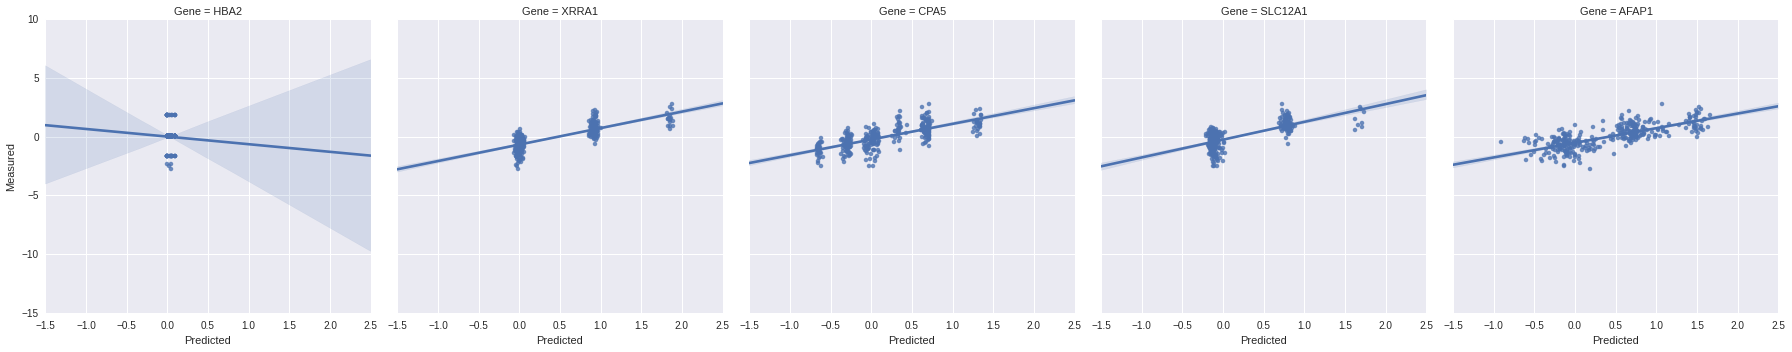

In [263]:
multi_gene_plot(std_errors.head().index)

### Highest standard deviations

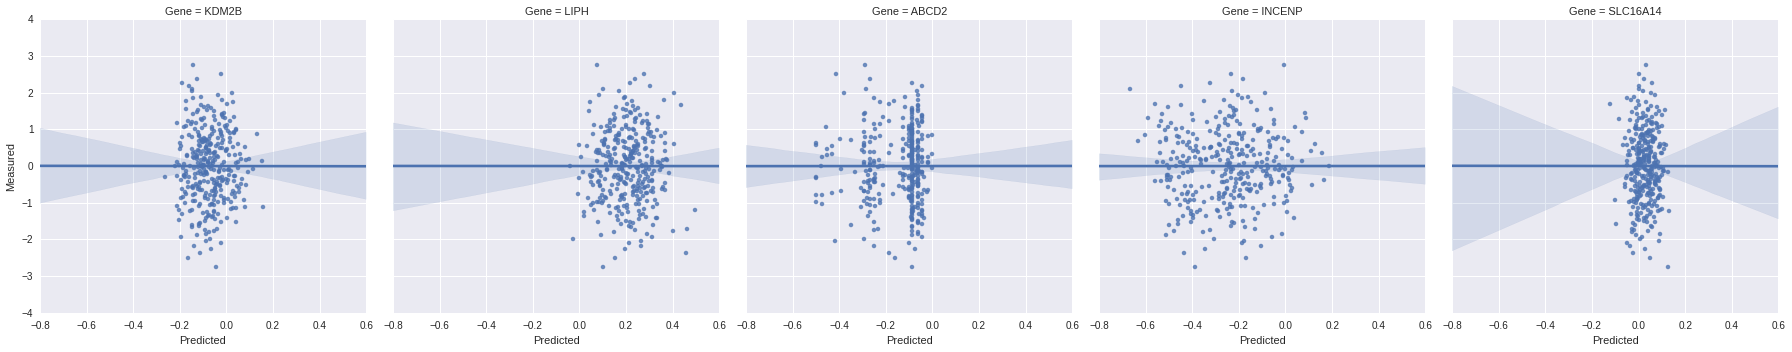

In [264]:
multi_gene_plot(std_errors.head().index)

#### Combine coef, std error on coef, and residual std.

In [229]:
combined_df = pd.concat([pd.DataFrame(coefficients), pd.DataFrame(std_errors).T])
combined_df.index = ['Coefficient', 'SE-Coef', 'SD-Residuals']

In [230]:
combined_df

,A2M,A4GALT,AACS,AAGAB,AAK1,AAMP,AANAT,AARS,AARS2,AARSD1,...,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZWILCH,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Coefficient,0.025215,0.482674,-0.071435,0.179356,-1.603465,0.010884,0.222718,1.161682,0.110487,-0.020868,...,0.141873,0.346763,-1.079445,0.714465,-0.014104,0.446673,0.481809,0.239906,-0.170556,-0.123236
SE-Coef,0.174900,0.091171,0.210400,0.428029,1.237511,0.450089,0.091992,1.462688,0.445290,0.378384,...,0.304549,1.267211,0.725990,0.698448,0.711294,0.414923,0.276897,0.085134,0.432879,0.942281
SD-Residuals,0.986583,0.929124,0.986380,0.986217,0.984121,0.986629,0.972074,0.985114,0.986500,0.986625,...,0.986304,0.986494,0.981833,0.984678,0.986632,0.984122,0.981343,0.966543,0.986339,0.986600


#### Let's add information about the variance of the predictions

In [238]:
std_predictors = pd.DataFrame(predicted.std(axis=1)).T
std_predictors.index = ['SD-Prediction']

In [239]:
combined_df = pd.concat([combined_df, std_predictors])

In [242]:
combined_df.dropna(axis=1)

,A2M,A4GALT,AACS,AAGAB,AAK1,AAMP,AANAT,AARS,AARS2,AARSD1,...,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZWILCH,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Coefficient,0.025215,0.482674,-0.071435,0.179356,-1.603465,0.010884,0.222718,1.161682,0.110487,-0.020868,...,0.141873,0.346763,-1.079445,0.714465,-0.014104,0.446673,0.481809,0.239906,-0.170556,-0.123236
SE-Coef,0.174900,0.091171,0.210400,0.428029,1.237511,0.450089,0.091992,1.462688,0.445290,0.378384,...,0.304549,1.267211,0.725990,0.698448,0.711294,0.414923,0.276897,0.085134,0.432879,0.942281
SD-Residuals,0.986583,0.929124,0.986380,0.986217,0.984121,0.986629,0.972074,0.985114,0.986500,0.986625,...,0.986304,0.986494,0.981833,0.984678,0.986632,0.984122,0.981343,0.966543,0.986339,0.986600
SD-Prediction,0.184727,0.417982,0.185680,0.077466,0.042314,0.064178,0.311882,0.021870,0.087731,0.075593,...,0.169779,0.037063,0.051641,0.063764,0.043674,0.093130,0.171103,0.329471,0.109996,0.058781


In [250]:
def calculate_reliability_ratio(series):
    variance_x = np.power(series['SD-Prediction'], 2)
    variance_error = np.power(series['SD-Residuals'], 2)
    return (variance_x - variance_error) / variance_x

In [252]:
combined_df.ix['Reliability-Ratio'] = combined_df.apply(calculate_reliability_ratio)

In [256]:
reliability_ratio = combined_df.ix['Reliability-Ratio'].map(abs)
reliability_ratio.sort()

In [266]:
combined_df[reliability_ratio.head().index]

,C17orf97,IGHMBP2,AFAP1,XRRA1,BEGAIN
Coefficient,0.700380,0.936774,0.827686,0.805848,0.431637
SE-Coef,0.055015,0.062696,0.059514,0.058596,0.048768
SD-Residuals,0.722190,0.712114,0.706581,0.688829,0.826293
SD-Prediction,0.605294,0.596348,0.582610,0.562772,0.645360
Reliability-Ratio,-0.423544,-0.425934,-0.470849,-0.498162,-0.639321


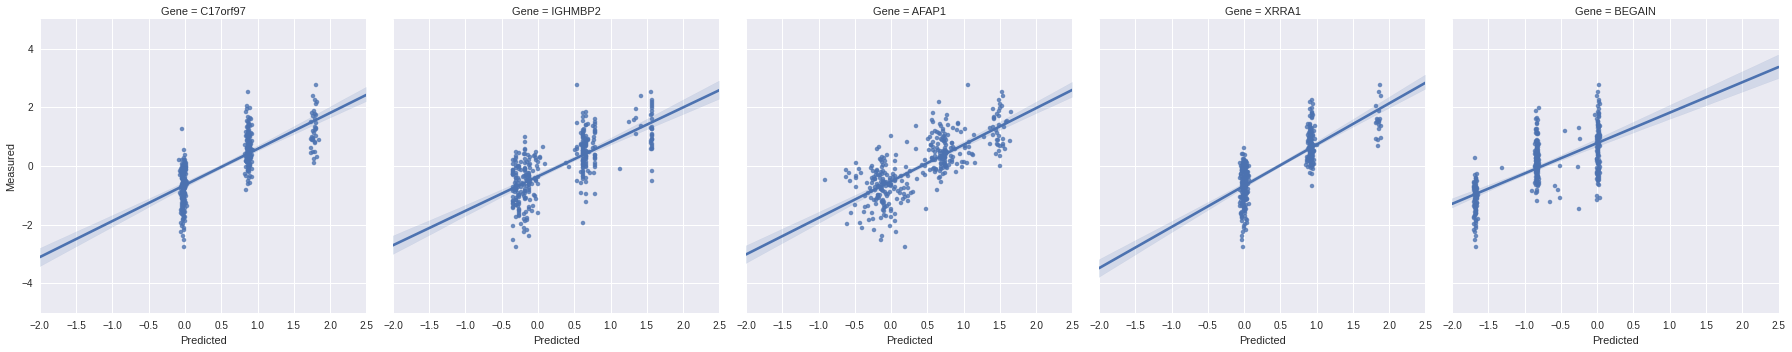

In [265]:
multi_gene_plot(reliability_ratio.head().index)

### Need to think about scale of these items